In [1]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
from skimage import color
from scipy.spatial import ConvexHull
import os
import random
import matplotlib.pyplot as plt

In [2]:
def load_image_sample(datapath: str, count: int = None, dimensions: tuple = None, as_array: bool = True):
    """
    Load a sample of images from a directory.

    Args:
        datapath (str): Path to the directory containing images.
        count (int, optional): Number of images to sample. If None, load all.
        dimensions (tuple, optional): Resize dimensions (width, height).
        as_array (bool): If True, return images as numpy arrays.

    Returns:
        list: List of images as PIL images or numpy arrays.
    """
    imgs = os.listdir(datapath)
    sample_indexes = range(len(imgs)) if count is None else random.sample(range(len(imgs)), count)

    images = []
    for i in sample_indexes:
        img_path = os.path.join(datapath, imgs[i])
        img = Image.open(img_path)
        if dimensions:
            img = img.resize(dimensions)
        if as_array:
            img = np.array(img)
        images.append(img)

    return images


In [3]:
def segment_leaf(image: Image.Image, resolution: tuple = (50, 50)) -> Image.Image:
    """
    Segment the leaf from an image using KMeans clustering in LAB color space.

    Args:
        image (PIL.Image): Input image.
        resolution (tuple): Resize resolution for clustering.

    Returns:
        PIL.Image: Image with leaf segmented.
    """
    original_size = image.size
    original_image_array = np.array(image)

    # Resize image and convert to LAB color space
    resized_image = image.resize(resolution)
    image_array_lab = color.rgb2lab(np.array(resized_image))

    # Apply KMeans clustering
    flat_lab = image_array_lab.reshape(-1, 3)
    model = KMeans(n_clusters=8)
    labels = model.fit_predict(flat_lab)

    # Create binary mask using color thresholds
    binary_mask = np.array([
        1 if center[1] < -10 and center[0] > 10 else 0
        for center in model.cluster_centers_
    ])
    binary = binary_mask[labels].reshape(resolution[::-1])

    # Identify leaf coordinates
    leaf_coords = np.array([
        [j, binary.shape[1] - i]
        for i in range(binary.shape[0])
        for j in range(binary.shape[1])
        if binary[i, j] == 1
    ])

    if leaf_coords.size == 0:
        print("No leaf coordinates identified, skipping segmentation.")
        return image

    # Convex hull to fill the leaf shape
    hull = ConvexHull(leaf_coords)
    samples = np.array([
        [i, j] for i in range(binary.shape[0]) for j in range(binary.shape[1])
    ])
    inside = (hull.equations @ np.c_[samples, np.ones(len(samples))].T < -1e-9).all(0)
    full_hull = samples[inside]

    for y, x in full_hull:
        binary[binary.shape[0] - x][y] = 1

    # Apply mask to original image
    binary_colors = np.array([[0, 0, 0], [1, 1, 1]], dtype=np.uint8)
    rgb_binary = np.array(Image.fromarray(binary_colors[binary]).resize(original_size))
    segmented_array = np.uint8(rgb_binary * original_image_array)

    return Image.fromarray(segmented_array)


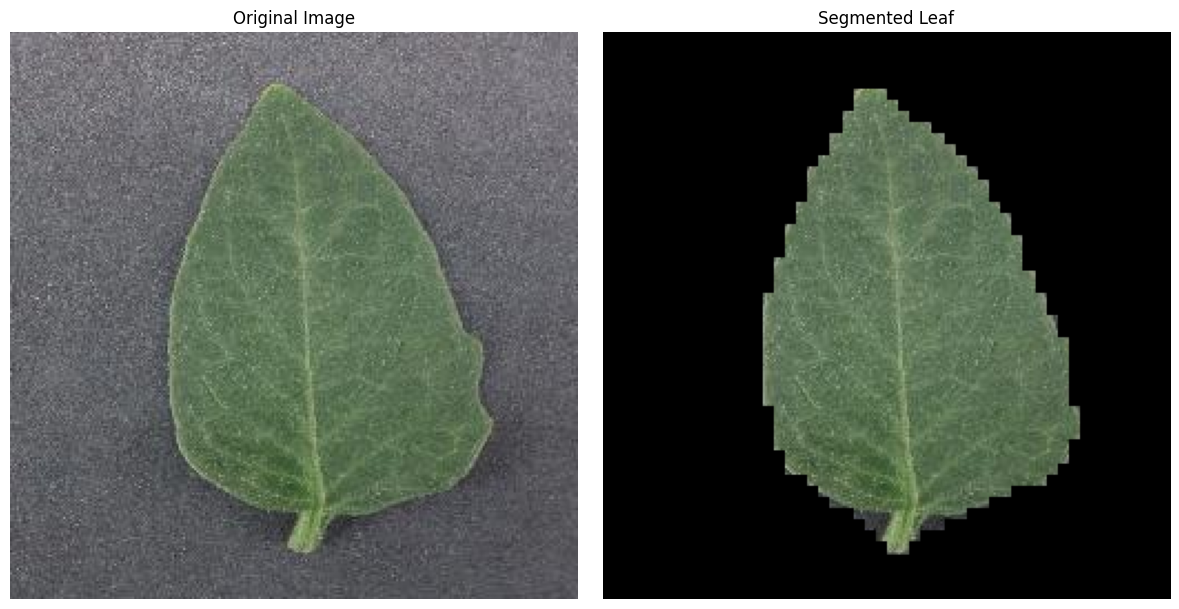

In [4]:
# Load the image
image_path = 'healthy_125.JPG'
image = Image.open(image_path)

# Segment the leaf
segmented = segment_leaf(image)

# Show original and segmented
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(segmented)
axs[1].set_title('Segmented Leaf')
axs[1].axis('off')

plt.tight_layout()
plt.show()
